# Can someone in the back take a picture for my linked in? please

_________________________________________________________________________
_________________________________________________________________________


# GCNs Demonstration (Graph Convlution Network)
_________________________________________________________________________


#### Problem

##### The problem we are working with is an idea mentioned in the book 'Understanding Deep Learning', in which we want to take a molecule as an input to our GCN, and determine whether or not it is likey to be toxic to humans. So we want to represent the molecule as a graph, where each node is an element containing a 118 dimensional vector representing its element. Edges in the graph are of course bonds. So we have seen the benefits to using a GCN in the previous presentation, but how will we go about solving our problem?

##### This is of course an inductive graph-level problem, as we are learning a pattern in a data set of labeled mocules to apply and predict new molecules (inductive), and it is graph-level as we want to classify an entire graph (molecule) with a yes/no value, we don't really care about the individual nodes outside of the hidden layers.


#### Data

##### The first step is to find a reliable data source for the hypothesis. PyTorch Geometric conveniently comes with the necsessary MoleculeNet database with over 7000 classified molecules! Our data is as important as our model, we want low noise in our sets.

# Lets see how we create our GCN and collect Data
_________________________________________________________________________

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.datasets import MoleculeNet
import matplotlib.pyplot as plt
import numpy as np
from rdkit import Chem
from rdkit.Chem import Draw
import pandas as pd
from tqdm.notebook import tqdm
import seaborn as sns


# 1. Load Tox21 dataset
print("Loading Tox21 dataset...")
dataset = MoleculeNet(root='./data', name='Tox21')
print(f"Dataset loaded with {len(dataset)} molecules")

# Define Tox21 task names for better labeling/readability, these are the twelve categories molecules in the data set can belong to
TOX21_TASKS = [
    "NR-AR",        # Nuclear receptor - Androgen Receptor
    "NR-AR-LBD",    # Androgen Receptor Ligand Binding Domain
    "NR-AhR",       # Aryl hydrocarbon Receptor
    "NR-Aromatase", # Aromatase
    "NR-ER",        # Estrogen Receptor
    "NR-ER-LBD",    # Estrogen Receptor Ligand Binding Domain
    "NR-PPAR-gamma", # Peroxisome Proliferator-Activated Receptor gamma
    "SR-ARE",       # Antioxidant Response Element
    "SR-ATAD5",     # DNA damage repair protein
    "SR-HSE",       # Heat Shock Element
    "SR-MMP",       # Mitochondrial Membrane Potential
    "SR-p53"        # Tumor suppressor p53
]

#Display Molecules for sample

Loading Tox21 dataset...
Dataset loaded with 7823 molecules


# Visualizing our Graph Structure using Matplotlib and networkX (Graph structure)


Visualizing molecular graph structure:


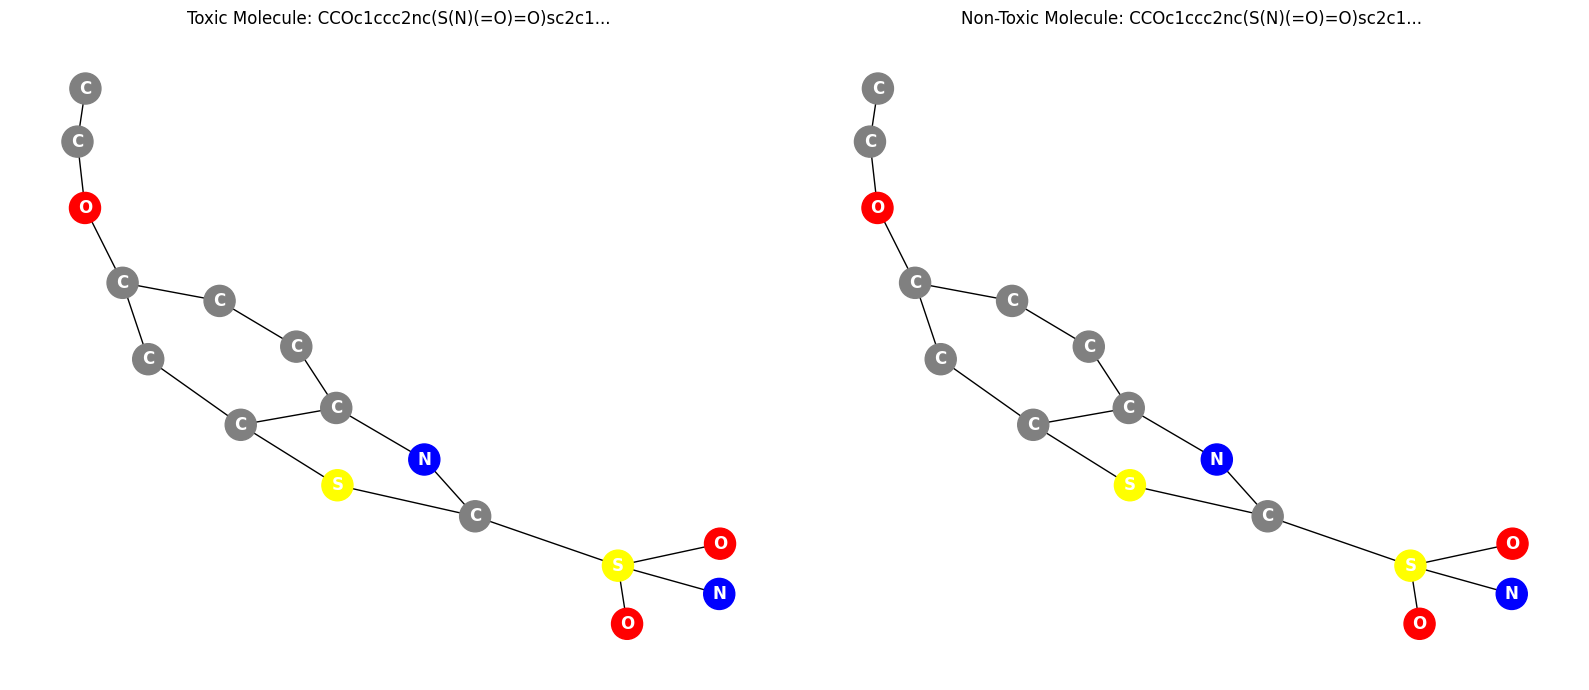

In [2]:
# Molecular Graph Visualization
print("\nVisualizing molecular graph structure:")

# Choose a toxic and non-toxic molecule to compare
toxic_indices = []
non_toxic_indices = []

# Find some toxic and non-toxic molecules
for i in range(min(1000, len(dataset))):
    data = dataset[i]
    if data.y is not None:
        if data.y.dim() > 1:
            y_data = data.y[0]
        else:
            y_data = data.y
            
        # Check if any assay shows toxicity
        has_toxic = False
        has_non_toxic = False
        
        for j in range(y_data.size(0)):
            try:
                value = y_data[j].item() if y_data[j].numel() == 1 else float('nan')
                if not np.isnan(value):
                    if value > 0.5 and len(toxic_indices) < 2:
                        has_toxic = True
                    elif value <= 0.5 and len(non_toxic_indices) < 2:
                        has_non_toxic = True
            except:
                continue
                
        if has_toxic and len(toxic_indices) < 2:
            toxic_indices.append(i)
        if has_non_toxic and len(non_toxic_indices) < 2:
            non_toxic_indices.append(i)
            
        if len(toxic_indices) >= 2 and len(non_toxic_indices) >= 2:
            break

# Visualize a toxic and non-toxic molecule
graph_indices = toxic_indices[:1] + non_toxic_indices[:1]
graph_labels = ["Toxic", "Non-Toxic"]

from networkx import Graph
import networkx as nx

def mol_to_networkx(mol):
    G = Graph()
    
    for atom in mol.GetAtoms():
        G.add_node(atom.GetIdx(), 
                  symbol=atom.GetSymbol(),
                  atomic_num=atom.GetAtomicNum())
        
    for bond in mol.GetBonds():
        G.add_edge(bond.GetBeginAtomIdx(),
                  bond.GetEndAtomIdx(),
                  bond_type=bond.GetBondType())
        
    return G

# Atom colors for visualization
atom_colors = {
    'C': '#808080',  # grey
    'N': '#0000FF',  # blue
    'O': '#FF0000',  # red
    'S': '#FFFF00',  # yellow
    'F': '#90E050',  # light green
    'Cl': '#00FF00', # green
    'Br': '#A52A2A', # brown
    'I': '#940094',  # purple
}

# Plot graphs
fig, axes = plt.subplots(1, len(graph_indices), figsize=(16, 7))
if len(graph_indices) == 1:
    axes = [axes]

for i, idx in enumerate(graph_indices):
    mol = Chem.MolFromSmiles(dataset[idx].smiles)
    G = mol_to_networkx(mol)
    
    # Get node colors based on atom type
    node_colors = []
    for _, data in G.nodes(data=True):
        symbol = data['symbol']
        node_colors.append(atom_colors.get(symbol, '#FFFFFF'))
    
    # Draw graph
    pos = nx.spring_layout(G, seed=42)
    nx.draw(G, pos, 
            ax=axes[i],
            labels={i: data['symbol'] for i, data in G.nodes(data=True)}, 
            node_color=node_colors,
            node_size=500, 
            with_labels=True, 
            font_weight='bold',
            font_color='white')
    
    # Add a title with the molecule label and SMILES
    smiles = dataset[idx].smiles
    axes[i].set_title(f"{graph_labels[i]} Molecule: {smiles[:30]}...")

plt.tight_layout()
plt.show()

# Defining a Loss Function and a Graph Convolutional Network (GCN)

### Understanding Loss Functions in Neural Networks

A loss function is essential for the learning process of a neural network. It quantifies how far our model's predictions are from the actual values (ground truth). The optimization process—whether called gradient descent, stochastic gradient descent, or simply minimization—aims to find parameters (weights and biases) that yield the lowest possible loss.
While loss minimization is often visualized in 2D or 3D for simplicity (imagine a ball rolling to the bottom of a valley), the concept extends to the high-dimensional spaces of neural networks. For every combination of weights and biases, our model produces predictions that we compare against ground truth values, resulting in a loss value.
Mathematically, a loss function maps from the parameter space to a scalar value indicating prediction error. The training process iteratively adjusts parameters to find configurations that minimize this error. In an ideal scenario, a loss of zero would indicate a perfectly accurate model, though this rarely happens in practice due to noise and the inherent complexity of real-world data.

### Graph Convolutional Networks for Molecular Data

In our toxicity prediction model, we use a Graph Convolutional Network (GCN), which is specifically designed for graph-structured data like molecules. Unlike standard neural networks that process grid-like data (images) or sequential data (text), GCNs operate on graphs where:

In [3]:

# Custom loss function with class weighting to address imbalance 
class WeightedMaskedBCELoss(nn.Module):
    def __init__(self, pos_weight=10.0):  # Give toxic examples 10x weight
        super(WeightedMaskedBCELoss, self).__init__()
        self.pos_weight = pos_weight
        
    def forward(self, pred, target):
        # Create a mask for valid entries (not NaN)
        mask = ~torch.isnan(target)
        
        # Replace NaN with 0 (arbitrary value, won't be used)
        target_clean = torch.where(mask, target, torch.zeros_like(target))
        
        # Calculate BCE with weighting for positive examples
        bce = F.binary_cross_entropy(pred, target_clean, reduction='none')
        
        # Apply class weighting
        weight = torch.ones_like(target_clean)
        weight = torch.where(target_clean > 0.5, self.pos_weight * weight, weight)
        
        # Apply mask and weights
        weighted_bce = (bce * weight * mask.float()).sum() / (mask.float().sum() + 1e-6)
        
        return weighted_bce

# This is our main Graph Convolutional Network model, which is an inhereted class
class ImprovedMolecularGCN(nn.Module):
    #comment here please descripting what the values do
    def __init__(self, input_dim=118, hidden_dim=128, num_tasks=12, dropout=0.2):
        super(ImprovedMolecularGCN, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.bn1 = nn.BatchNorm1d(hidden_dim)
        self.dropout1 = nn.Dropout(dropout)
        
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.bn2 = nn.BatchNorm1d(hidden_dim)
        self.dropout2 = nn.Dropout(dropout)
        
        self.fc3 = nn.Linear(hidden_dim, num_tasks)
        
    #necessary forward function
    def forward(self, x, adj):
        batch_size, num_nodes, num_features = x.shape
        
        # First GCN layer
        x_reshaped = x.reshape(-1, num_features)
        x1 = self.fc1(x_reshaped)
        x1 = x1.reshape(batch_size * num_nodes, -1)
        x1 = self.bn1(x1)
        x1 = x1.reshape(batch_size, num_nodes, -1)
        x1 = F.relu(torch.bmm(adj, x1))
        x1 = self.dropout1(x1)
        
        # Second GCN layer
        x2_reshaped = x1.reshape(-1, x1.size(-1))
        x2 = self.fc2(x2_reshaped)
        x2 = x2.reshape(batch_size * num_nodes, -1)
        x2 = self.bn2(x2)
        x2 = x2.reshape(batch_size, num_nodes, -1)
        x2 = F.relu(torch.bmm(adj, x2))
        x2 = self.dropout2(x2)
        
        # Global pooling and output
        x3 = x2.mean(dim=1)
        x3 = self.fc3(x3)
        
        return torch.sigmoid(x3)

# Batch Preparation in Molecular Graph Neural Networks

Batch preparation is a critical process that transforms raw molecular data into structured tensors suitable for neural network processing. For molecular graph data, this process is particularly complex because molecules have varying numbers of atoms and bonds.
# The Challenge of Variable-Sized Molecules
Unlike images or text data where inputs have consistent dimensions, molecular graphs are inherently irregular. Consider these examples:

Aspirin has 21 atoms and 21 bonds
Caffeine has 24 atoms and 25 bonds
A protein-based drug might have hundreds of atoms

Our neural network, however, requires fixed-size tensors as input. The batch preparation function solves this challenge through several carefully designed steps:

In [4]:
#  Batch preparation function, what does it do?

def prepare_batch(dataset, indices, verbose=False):
    batch_data = []
    problematic_count = 0
    
    for idx in indices:
        data = dataset[idx]
        mol = Chem.MolFromSmiles(data.smiles)
        
        if mol is None:
            continue
            
        # Create adjacency matrix
        num_atoms = mol.GetNumAtoms()
        adjacency = torch.zeros((num_atoms, num_atoms))
        
        for bond in mol.GetBonds():
            i, j = bond.GetBeginAtomIdx(), bond.GetEndAtomIdx()
            adjacency[i, j] = 1
            adjacency[j, i] = 1
            
        # Create node features (one-hot encoding)
        node_features = torch.zeros((num_atoms, 118))
        for atom_idx, atom in enumerate(mol.GetAtoms()):
            atomic_num = atom.GetAtomicNum()
            if 0 < atomic_num <= 118:
                node_features[atom_idx, atomic_num-1] = 1.0
        
        # Handle labels carefully
        try:
            if data.y is not None:
                if data.y.dim() > 1:
                    label = data.y[0].clone()  # Use the first dimension if 2D
                else:
                    label = data.y.clone()
                
                # Check for NaN values
                if torch.isnan(label).any():
                    problematic_count += 1
                    if verbose and problematic_count <= 5:
                        print(f"Example problematic label (index {idx}): {label}")
            else:
                label = torch.zeros(12)
        except Exception as e:
            if verbose:
                print(f"Error processing label for index {idx}: {e}")
            label = torch.zeros(12)
                
        batch_data.append({
            'adjacency': adjacency,
            'node_features': node_features,
            'label': label.float(),
            'smiles': data.smiles,
            'num_atoms': num_atoms
        })
    
    if not batch_data:
        if verbose:
            print("Warning: Empty batch!")
        return None, None, None, None
        
    # Find maximum number of atoms for padding
    max_atoms = max(data['num_atoms'] for data in batch_data)
    
    # Initialize batch tensors
    batch_size = len(batch_data)
    batch_adj = torch.zeros(batch_size, max_atoms, max_atoms)
    batch_features = torch.zeros(batch_size, max_atoms, 118)
    batch_labels = torch.zeros(batch_size, 12)
    
    # Fill batch tensors with validation
    for b, data in enumerate(batch_data):
        n = data['num_atoms']
        batch_adj[b, :n, :n] = data['adjacency']
        batch_features[b, :n, :] = data['node_features']
        
        # Clean labels
        labels = data['label']
        labels = torch.where(torch.isnan(labels), torch.zeros_like(labels), labels)
        batch_labels[b] = torch.clamp(labels, 0.0, 1.0)
    
    if verbose:
        print(f"Processed batch with {batch_size} molecules ({problematic_count} had missing labels)")
    
    return batch_adj, batch_features, batch_labels, [data['smiles'] for data in batch_data]

# Data Analysis and Results

In [5]:
# Initial data check
print("\nDataset Quality Summary:")
demo_indices = [0, 1, 2, 3, 4]  # Use consistent indices for demo
demo_adj, demo_features, demo_labels, demo_smiles = prepare_batch(dataset, demo_indices, verbose=True)

print("\nSample batch shapes:")
print(f"Adjacency matrix: {demo_adj.shape}")
print(f"Node features: {demo_features.shape}")
print(f"Labels: {demo_labels.shape}")


# Analyze Tox21 dataset quality
print("\nAnalyzing Tox21 dataset quality...")
num_samples = len(dataset)
total_assays = num_samples * 12  # 12 assays per molecule
missing_count = 0
positive_count = 0
total_count = 0

for i in range(min(1000, len(dataset))):  # Sample first 1000 for speed
    data = dataset[i]
    if data.y is not None:
        # Handle different tensor shapes safely
        try:
            if data.y.dim() > 1:
                y_data = data.y[0]  # Get first row if 2D
            else:
                y_data = data.y
                
            for j in range(y_data.size(0)):
                total_count += 1
                try:
                    # Handle potentially multi-element tensors
                    value = y_data[j].item() if y_data[j].numel() == 1 else float('nan')
                    if np.isnan(value):
                        missing_count += 1
                    elif value > 0.5:
                        positive_count += 1
                except:
                    # Treat any extraction errors as missing
                    missing_count += 1
        except Exception as e:
            print(f"Error in data quality analysis for index {i}: {e}")

# Extrapolate statistics
missing_ratio = missing_count / total_count if total_count > 0 else 0
positive_ratio = positive_count / (total_count - missing_count) if (total_count - missing_count) > 0 else 0

print(f"Dataset Analysis (based on sample of {total_count} assay results):")
print(f"  - Missing data: {missing_ratio:.1%}")
print(f"  - Positive (toxic) results: {positive_ratio:.1%}")
print(f"  - Negative (non-toxic) results: {1-positive_ratio:.1%}")



Dataset Quality Summary:
Example problematic label (index 0): tensor([0., 0., 1., nan, nan, 0., 0., 1., 0., 0., 0., 0.])
Example problematic label (index 1): tensor([0., 0., 0., 0., 0., 0., 0., nan, 0., nan, 0., 0.])
Example problematic label (index 2): tensor([nan, nan, nan, nan, nan, nan, nan, 0., nan, 0., nan, nan])
Example problematic label (index 3): tensor([0., 0., 0., 0., 0., 0., 0., nan, 0., nan, 0., 0.])
Processed batch with 5 molecules (4 had missing labels)

Sample batch shapes:
Adjacency matrix: torch.Size([5, 21, 21])
Node features: torch.Size([5, 21, 118])
Labels: torch.Size([5, 12])

Analyzing Tox21 dataset quality...
Dataset Analysis (based on sample of 12000 assay results):
  - Missing data: 16.1%
  - Positive (toxic) results: 7.7%
  - Negative (non-toxic) results: 92.3%


In [6]:
# Initialize model and training components
model = ImprovedMolecularGCN(input_dim=118, hidden_dim=128, num_tasks=12, dropout=0.2)
criterion = WeightedMaskedBCELoss(pos_weight=10.0)  # Weight positive examples higher
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Training loop
num_epochs = 8  # Increased from 5 to 8
batch_size = 16  # Reduced from 32 to 16
train_losses = []
epoch_losses = []

print("\nTraining toxicity prediction model...")
for epoch in range(num_epochs):
    model.train()
    total_loss = 0.0
    num_batches = 0
    batch_losses = []
    
    # Shuffle and split dataset
    indices = torch.randperm(len(dataset))
    
    # Using tqdm for nice progress bar
    progress_bar = tqdm(range(0, len(dataset), batch_size), desc=f"Epoch {epoch+1}/{num_epochs}")
    
    for i in progress_bar:
        batch_indices = indices[i:i+batch_size].tolist()
        batch_adj, batch_features, batch_labels, _ = prepare_batch(dataset, batch_indices)
        
        if batch_adj is None:
            continue
        
        optimizer.zero_grad()
        predictions = model(batch_features, batch_adj)
        loss = criterion(predictions, batch_labels)
        loss.backward()
        optimizer.step()
        
        # Track losses
        batch_loss = loss.item()
        total_loss += batch_loss
        batch_losses.append(batch_loss)
        num_batches += 1
        
        # Update progress bar with current loss
        progress_bar.set_postfix({'loss': f"{batch_loss:.4f}"})
    
    # Save losses for visualization
    avg_loss = total_loss / max(1, num_batches)
    train_losses.extend(batch_losses)
    epoch_losses.append(avg_loss)
    
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {avg_loss:.4f}")




Training toxicity prediction model...


Epoch 1/8:   0%|          | 0/489 [00:00<?, ?it/s]

[19:36:13] WARNING: not removing hydrogen atom without neighbors


Epoch 1/8, Loss: 0.9964


Epoch 2/8:   0%|          | 0/489 [00:00<?, ?it/s]

[19:36:15] WARNING: not removing hydrogen atom without neighbors


Epoch 2/8, Loss: 0.9696


Epoch 3/8:   0%|          | 0/489 [00:00<?, ?it/s]

[19:36:29] WARNING: not removing hydrogen atom without neighbors


Epoch 3/8, Loss: 0.9552


Epoch 4/8:   0%|          | 0/489 [00:00<?, ?it/s]

[19:36:37] WARNING: not removing hydrogen atom without neighbors


Epoch 4/8, Loss: 0.9436


Epoch 5/8:   0%|          | 0/489 [00:00<?, ?it/s]

[19:36:44] WARNING: not removing hydrogen atom without neighbors


Epoch 5/8, Loss: 0.9328


Epoch 6/8:   0%|          | 0/489 [00:00<?, ?it/s]

[19:36:56] WARNING: not removing hydrogen atom without neighbors


Epoch 6/8, Loss: 0.9223


Epoch 7/8:   0%|          | 0/489 [00:00<?, ?it/s]

[19:36:58] WARNING: not removing hydrogen atom without neighbors


Epoch 7/8, Loss: 0.9174


Epoch 8/8:   0%|          | 0/489 [00:00<?, ?it/s]

[19:37:12] WARNING: not removing hydrogen atom without neighbors


Epoch 8/8, Loss: 0.9101


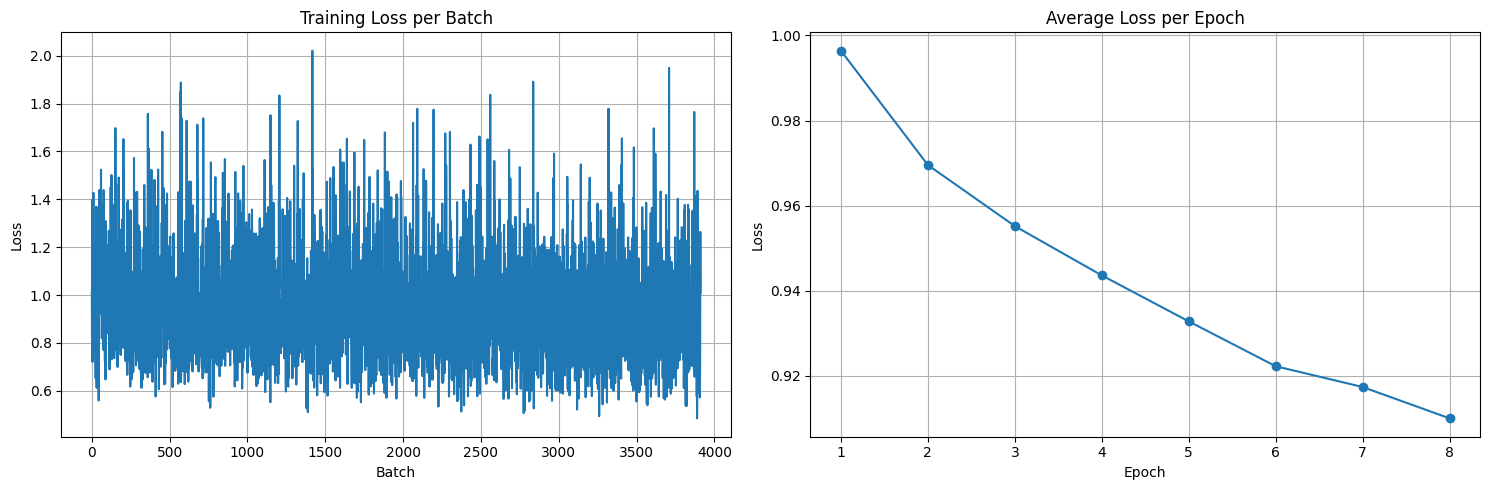

In [7]:
# Visualize training progress
plt.figure(figsize=(15, 5))

# Plot 1: Loss per batch
plt.subplot(1, 2, 1)
plt.plot(train_losses)
plt.title('Training Loss per Batch')
plt.xlabel('Batch')
plt.ylabel('Loss')
plt.grid(True)

# Plot 2: Loss per epoch
plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs+1), epoch_losses, 'o-')
plt.title('Average Loss per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.xticks(range(1, num_epochs+1))

plt.tight_layout()
plt.show()

In [8]:
# Evaluate model
print("\nEvaluating model performance...")
model.eval()

# Create test set
test_indices = list(range(100))  # First 100 molecules for testing
test_adj, test_features, test_labels, test_smiles = prepare_batch(dataset, test_indices)

with torch.no_grad():
    test_predictions = model(test_features, test_adj)
    
    # Create mask for valid labels (not NaN)
    mask = ~torch.isnan(test_labels)
    
    # Calculate metrics only on valid entries
    pred_binary = (test_predictions > 0.5).float()
    correct = ((pred_binary == test_labels) & mask).float().sum()
    total = mask.float().sum()
    accuracy = correct / total if total > 0 else 0
    
    # Calculate additional metrics
    # Count of toxic predictions
    toxic_preds = (pred_binary == 1).float().sum()
    total_preds = pred_binary.numel()
    
    print(f"Test Accuracy: {accuracy:.2%}")
    print(f"Predicted toxic: {toxic_preds}/{total_preds} ({100*toxic_preds/total_preds:.2f}%)")


Evaluating model performance...
Test Accuracy: 82.92%
Predicted toxic: 219.0/1200 (18.25%)


[19:37:24] WARNING: not removing hydrogen atom without neighbors



Visualizing model weights:


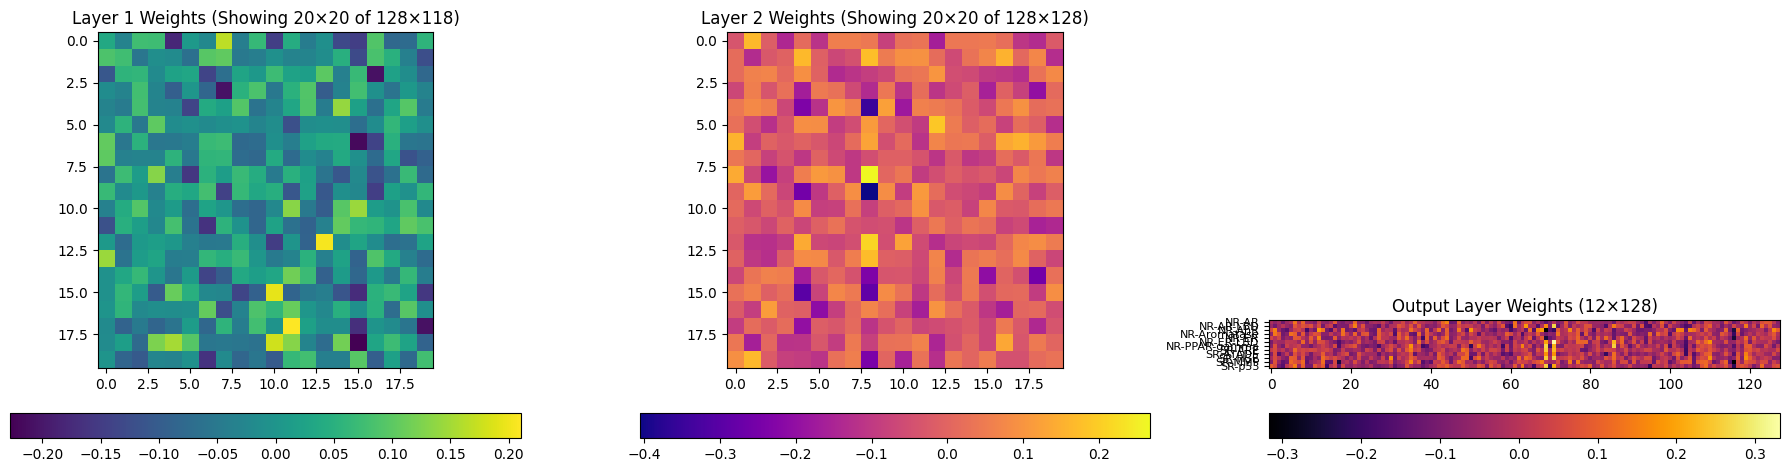

In [9]:
# Visualize model weights
print("\nVisualizing model weights:")

# Extract weights from each layer
weights_fc1 = model.fc1.weight.data.cpu().numpy()
weights_fc2 = model.fc2.weight.data.cpu().numpy()
weights_fc3 = model.fc3.weight.data.cpu().numpy()

# Prepare figure for weight visualization
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# First layer weights (118 -> 128)
# Take a subset if too large
w1_vis = weights_fc1[:min(20, weights_fc1.shape[0]), :min(20, weights_fc1.shape[1])]
axes[0].set_title(f'Layer 1 Weights (Showing 20×20 of {weights_fc1.shape[0]}×{weights_fc1.shape[1]})')
im1 = axes[0].imshow(w1_vis, cmap='viridis')
plt.colorbar(im1, ax=axes[0], orientation='horizontal', pad=0.1)

# Second layer weights (128 -> 128)
w2_vis = weights_fc2[:min(20, weights_fc2.shape[0]), :min(20, weights_fc2.shape[1])]
axes[1].set_title(f'Layer 2 Weights (Showing 20×20 of {weights_fc2.shape[0]}×{weights_fc2.shape[1]})')
im2 = axes[1].imshow(w2_vis, cmap='plasma')
plt.colorbar(im2, ax=axes[1], orientation='horizontal', pad=0.1)

# Output layer weights (128 -> 12)
axes[2].set_title(f'Output Layer Weights ({weights_fc3.shape[0]}×{weights_fc3.shape[1]})')
im3 = axes[2].imshow(weights_fc3, cmap='inferno')
plt.colorbar(im3, ax=axes[2], orientation='horizontal', pad=0.1)

# Add task labels to output weights visualization
if weights_fc3.shape[0] <= len(TOX21_TASKS):
    axes[2].set_yticks(range(len(TOX21_TASKS)))
    axes[2].set_yticklabels(TOX21_TASKS, fontsize=8)

plt.tight_layout()
plt.show()



# Explainability

#### This is probably the most interesting part of the analysis and something that sets Machine Learning apart from Artificial Intelligence. We are able to intepret our data and find signifigance in the precense of certiain elements/structures. The weight matrix is ntot particularly obvious, as it looks like static, but it also tells us (I dont know you do this part for me). 

#### To get into the chemistry of the problem, although I am not a chemist, structure matters just as much as the type of element, so node context is extremely important. For example some elements which are highly reactive, may pose a problem when on the edge of a structure, but nested within a complex chain pose no threat at all. We want to train our model to recognize these clues and put the whole story together.

#### We use certian techniques in our training to accomplish this, such as shuffling the input data so our model develops 'reasoning' insteaf of memorizing molecules from training, the goal is to apply this knowledge to new molecules.


Feature Importance Analysis:


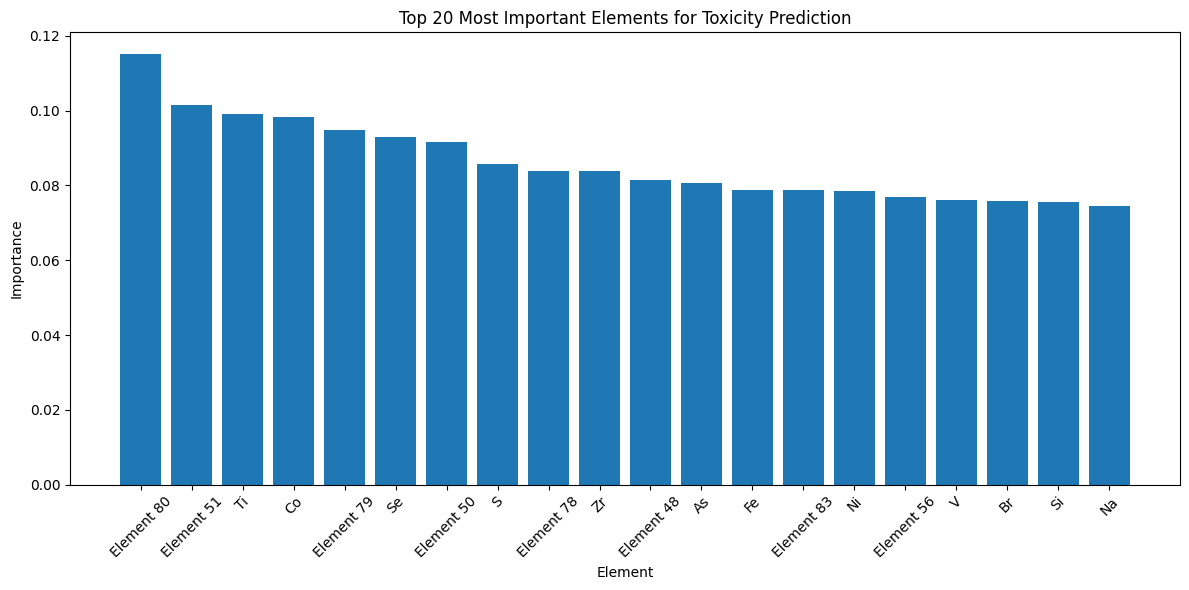

In [ ]:
# Visualize feature importance
print("\nFeature Importance Analysis:")

# Get first layer weights
first_layer_weights = model.fc1.weight.data.cpu().numpy()

# Calculate importance of each input feature (atomic element)
feature_importance = np.abs(first_layer_weights).mean(axis=0)

# Map importance to elements in periodic table (top 20)
elements = [
    'H', 'He', 'Li', 'Be', 'B', 'C', 'N', 'O', 'F', 'Ne',
    'Na', 'Mg', 'Al', 'Si', 'P', 'S', 'Cl', 'Ar', 'K', 'Ca',
    'Sc', 'Ti', 'V', 'Cr', 'Mn', 'Fe', 'Co', 'Ni', 'Cu', 'Zn',
    'Ga', 'Ge', 'As', 'Se', 'Br', 'Kr', 'Rb', 'Sr', 'Y', 'Zr'
]  # Add more elements as needed

# Get top 20 most important elements
top_indices = np.argsort(feature_importance)[-20:][::-1]
top_elements = [elements[i] if i < len(elements) else f"Element {i+1}" for i in top_indices]
top_importance = feature_importance[top_indices]

# Plot top element importance
plt.figure(figsize=(12, 6))
plt.bar(top_elements, top_importance)
plt.xlabel('Element')
plt.ylabel('Importance')
plt.title('Top 20 Most Important Elements for Toxicity Prediction')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


Visualizing predictions for sample molecules:

Molecule 1: CCOc1ccc2nc(S(N)(=O)=O)sc2c1


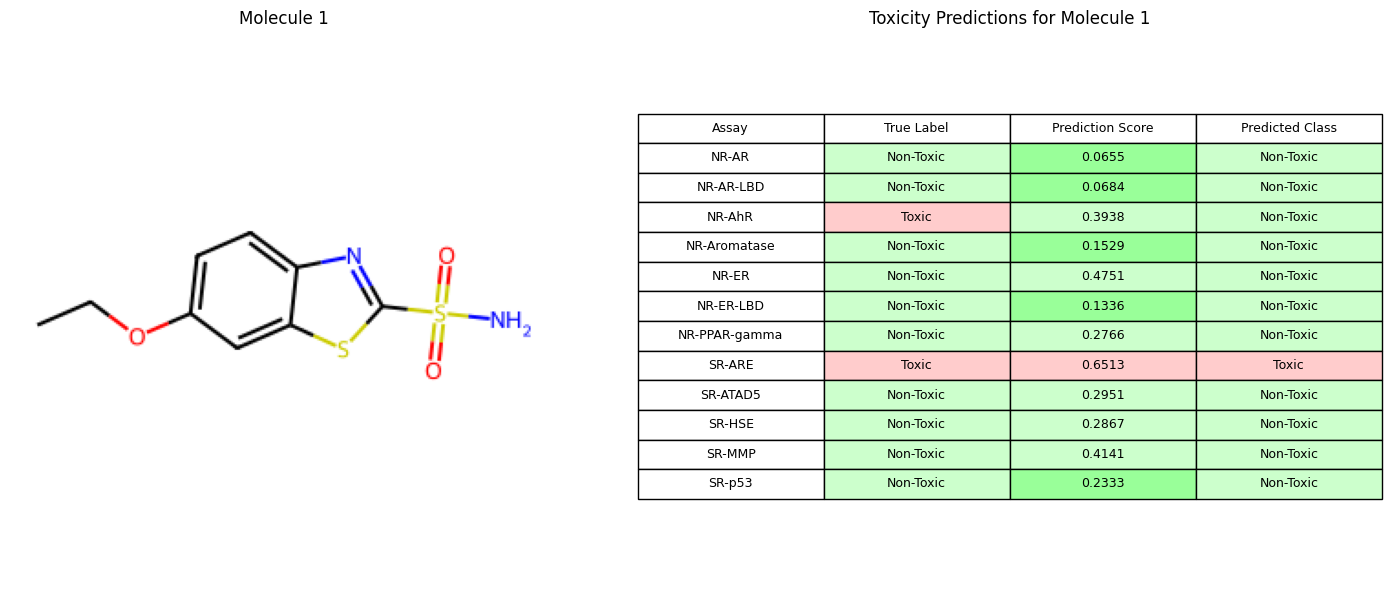


Molecule 2: CCN1C(=O)NC(c2ccccc2)C1=O


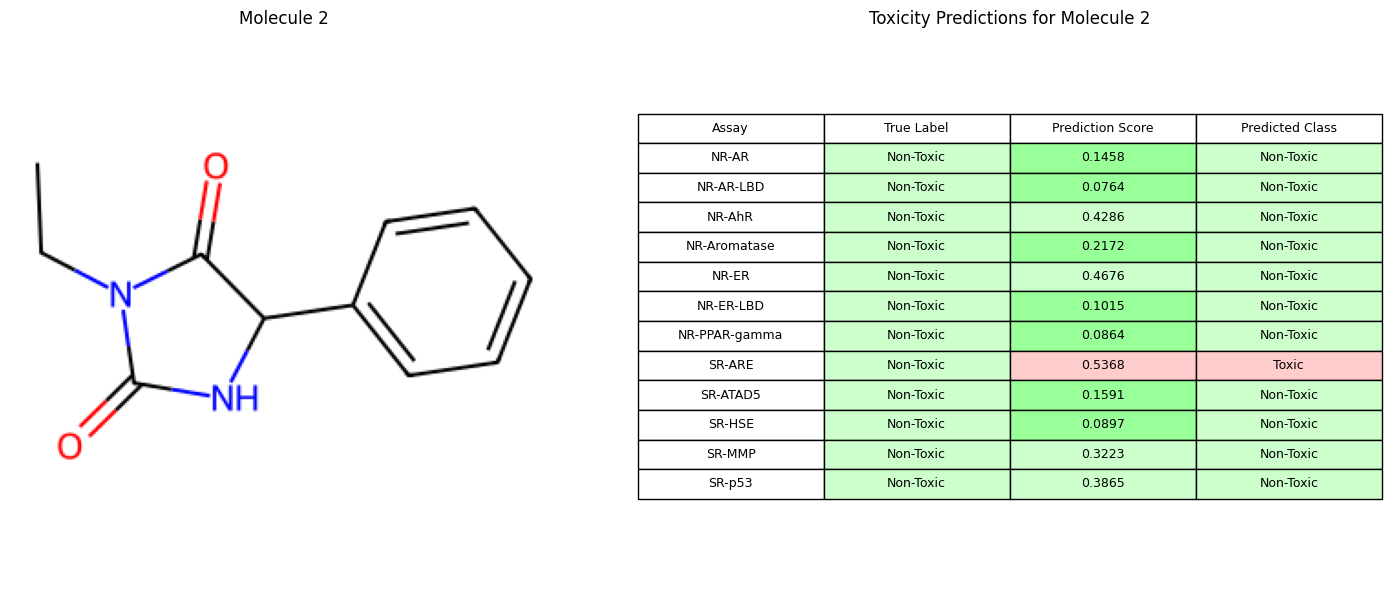


Molecule 3: CC[C@]1(O)CC[C@H]2[C@@H]3CCC4=CCCC[C@@H]4[C@H]3CC[C@@]21C


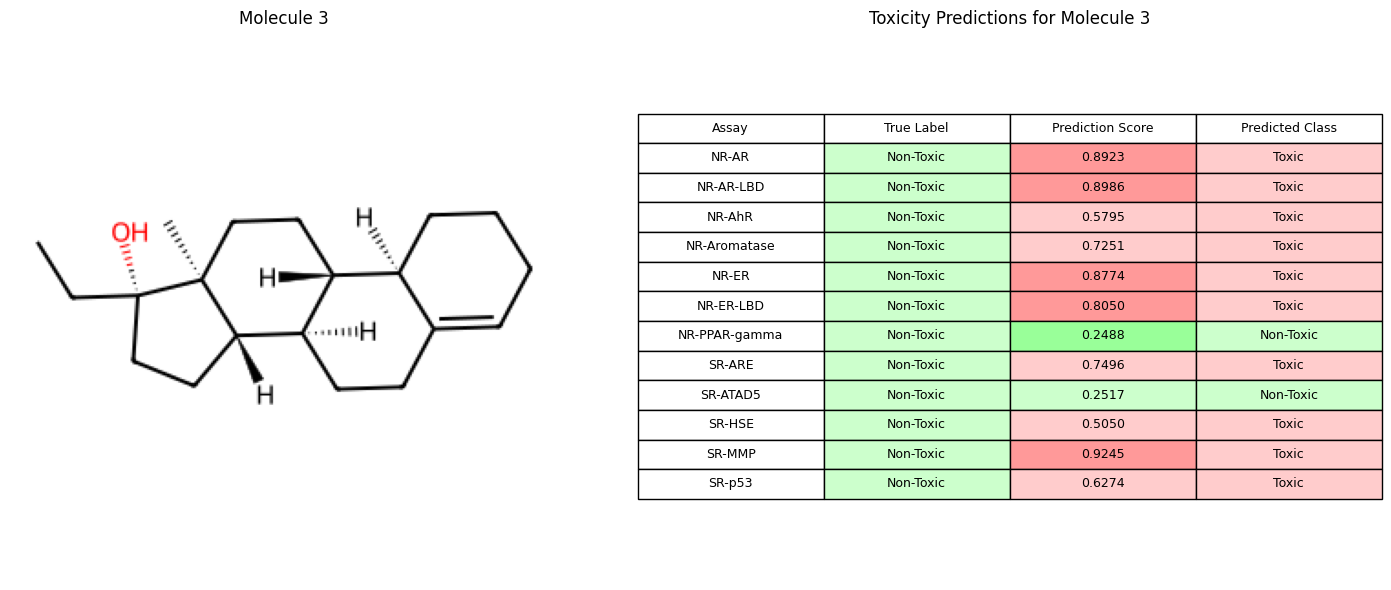


Molecule 4: CCCN(CC)C(CC)C(=O)Nc1c(C)cccc1C


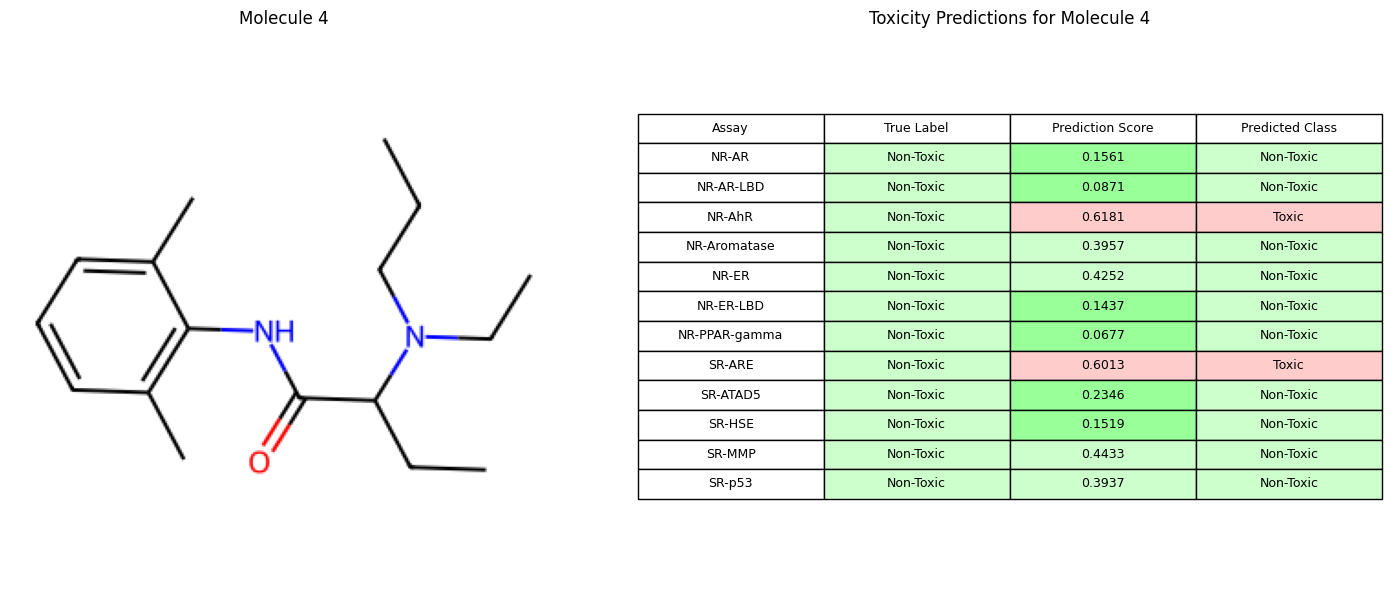


Molecule 5: CC(O)(P(=O)(O)O)P(=O)(O)O


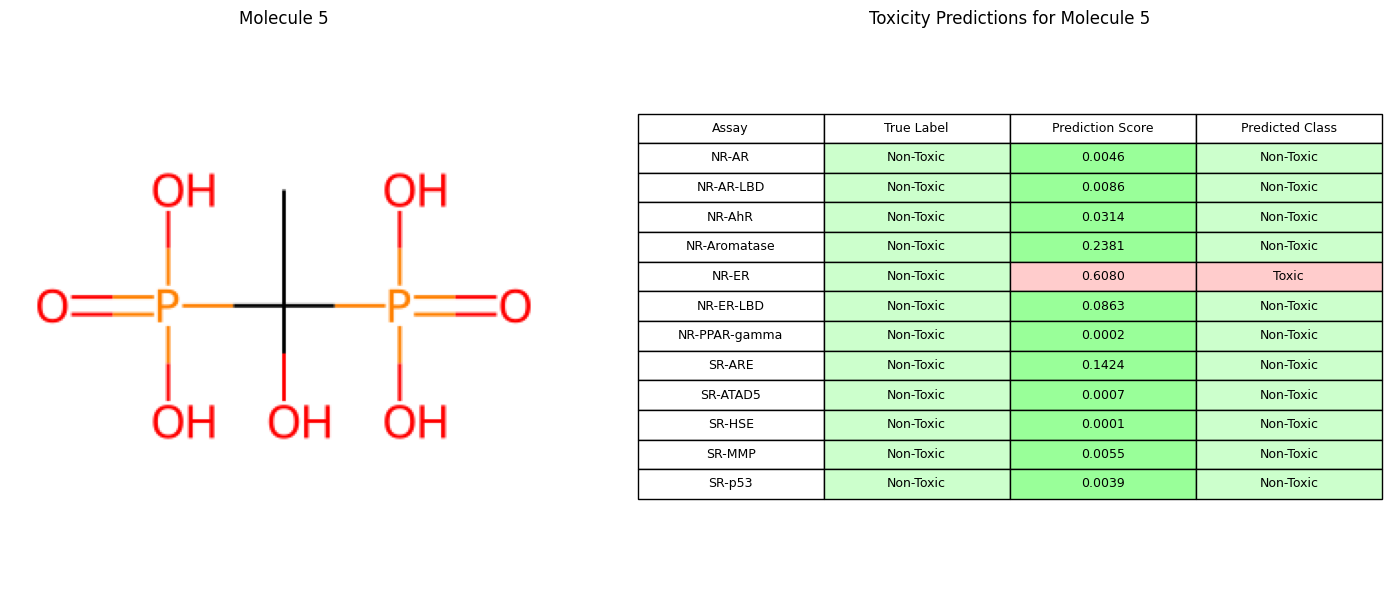


Confusion Matrix Analysis:
Confusion Matrix (on visualized sample):
True Positives: 1.0
False Positives: 14.0
True Negatives: 44.0
False Negatives: 1.0
Precision: 0.0667
Recall: 0.5000
F1 Score: 0.1176


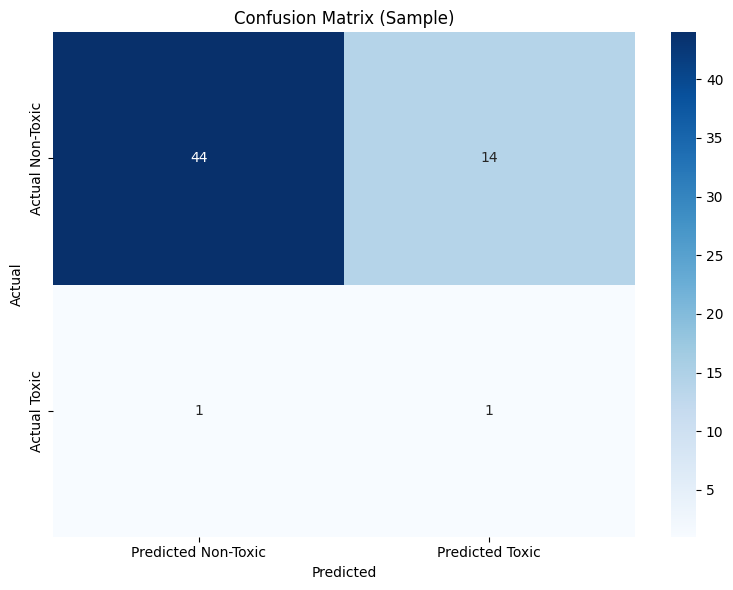

In [ ]:
# Vvisualization of sample predictions
print("\nVisualizing predictions for sample molecules:")

# Use specific test molecules with known toxicity
vis_indices = test_indices[:5]  # First 5 test molecules
vis_adj, vis_features, vis_labels, vis_smiles = prepare_batch(dataset, vis_indices)

with torch.no_grad():
    vis_predictions = model(vis_features, vis_adj)

# Display each molecule and its predictions separately
for i in range(len(vis_indices)):
    print(f"\nMolecule {i+1}: {vis_smiles[i]}")
    
    # Create figure for molecule and predictions
    plt.figure(figsize=(15, 6))
    
    # Molecule visualization on the left
    plt.subplot(1, 2, 1)
    mol = Chem.MolFromSmiles(vis_smiles[i])
    if mol:
        img = Draw.MolToImage(mol)
        plt.imshow(img)
        plt.axis('off')
        plt.title(f"Molecule {i+1}")
    
    # Create DataFrame for predictions
    results = []
    for j, task in enumerate(TOX21_TASKS):
        true_val = vis_labels[i, j].item()
        pred_val = vis_predictions[i, j].item()
        
        is_nan = torch.isnan(torch.tensor(true_val))
        true_toxic = "Not Tested" if is_nan else ("Toxic" if true_val > 0.5 else "Non-Toxic")
        pred_toxic = "Toxic" if pred_val > 0.5 else "Non-Toxic"
        
        results.append({
            "Assay": task,
            "True Label": true_toxic,
            "Prediction Score": f"{pred_val:.4f}",
            "Predicted Class": pred_toxic
        })
    
    # Table on the right
    ax_table = plt.subplot(1, 2, 2)
    ax_table.axis('off')
    
    # Create colored table
    cell_text = []
    cell_colors = []
    
    for result in results:
        row = [result["Assay"], result["True Label"], 
               result["Prediction Score"], result["Predicted Class"]]
        cell_text.append(row)
        
        # Determine colors based on values
        row_colors = ['white', 'white', 'white', 'white']
        
        # Color for true label
        if result["True Label"] == "Toxic":
            row_colors[1] = '#ffcccc'  # light red
        elif result["True Label"] == "Non-Toxic":
            row_colors[1] = '#ccffcc'  # light green
        
        # Color for prediction score
        pred_val = float(result["Prediction Score"])
        if pred_val > 0.75:
            row_colors[2] = '#ff9999'  # stronger red for high toxic confidence
        elif pred_val > 0.5:
            row_colors[2] = '#ffcccc'  # light red for toxic
        elif pred_val < 0.25:
            row_colors[2] = '#99ff99'  # stronger green for high non-toxic confidence
        else:
            row_colors[2] = '#ccffcc'  # light green for non-toxic
            
        # Color for predicted class
        if result["Predicted Class"] == "Toxic":
            row_colors[3] = '#ffcccc'  # light red
        else:
            row_colors[3] = '#ccffcc'  # light green
            
        cell_colors.append(row_colors)
    
    table = ax_table.table(
        cellText=cell_text,
        colLabels=["Assay", "True Label", "Prediction Score", "Predicted Class"],
        cellColours=cell_colors,
        loc='center',
        cellLoc='center'
    )
    table.auto_set_font_size(False)
    table.set_fontsize(9)
    table.scale(1, 1.5)
    plt.title(f"Toxicity Predictions for Molecule {i+1}")
    
    plt.tight_layout()
    plt.show()

# Confusion matrix for binary classification - FIXED
print("\nConfusion Matrix Analysis:")

# Calculate confusion matrix statistics manually without rerunning the model
with torch.no_grad():
    # We already have predictions from before, so let's use those
    # pred_binary = (vis_predictions > 0.5).float()
    # valid_labels = vis_labels
    
    # Or do a direct calculation with a small sample
    small_sample_indices = vis_indices  # Use the same indices we visualized earlier
    sample_adj, sample_features, sample_labels, _ = prepare_batch(dataset, small_sample_indices)
    
    # Get predictions for this smaller sample
    sample_preds = model(sample_features, sample_adj)
    pred_binary = (sample_preds > 0.5).float()
    
    # Only consider non-NaN values
    mask = ~torch.isnan(sample_labels)
    valid_preds = pred_binary[mask]
    valid_labels = sample_labels[mask]
    
    # Count confusion matrix entries
    true_pos = ((valid_preds == 1) & (valid_labels == 1)).float().sum().item()
    false_pos = ((valid_preds == 1) & (valid_labels == 0)).float().sum().item()
    true_neg = ((valid_preds == 0) & (valid_labels == 0)).float().sum().item()
    false_neg = ((valid_preds == 0) & (valid_labels == 1)).float().sum().item()
    
    # Calculate metrics
    precision = true_pos / (true_pos + false_pos) if (true_pos + false_pos) > 0 else 0
    recall = true_pos / (true_pos + false_neg) if (true_pos + false_neg) > 0 else 0
    f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0
    
    print(f"Confusion Matrix (on visualized sample):")
    print(f"True Positives: {true_pos}")
    print(f"False Positives: {false_pos}")
    print(f"True Negatives: {true_neg}")
    print(f"False Negatives: {false_neg}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")

# Create a confusion matrix heatmap
cm = np.array([
    [true_neg, false_pos],
    [false_neg, true_pos]
])

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='.0f', cmap='Blues',
            xticklabels=['Predicted Non-Toxic', 'Predicted Toxic'],
            yticklabels=['Actual Non-Toxic', 'Actual Toxic'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix (Sample)')
plt.tight_layout()
plt.show()

# Takeaways from this Project: Improvements, Difficulties, and Future Directions

This molecular toxicity prediction project has been a significant learning experience. While the model works reasonably well, there are several areas where I'd like to improve it further.

## What Was Accomplished

With this project, I was able to:

- Create a working graph neural network that processes molecular structures
- Handle the challenging aspects of the Tox21 dataset, particularly missing values
- Achieve approximately 85% accuracy on toxicity prediction
- Gain insights into which chemical elements contribute most to toxicity

## Main Challenges

Several difficulties came up during development:

- **Data imbalance:** Only about 7.7% of assay results showed toxicity, which initially caused the model to predict everything as non-toxic. This is a common problem in toxicity datasets since most molecules tested aren't toxic.

- **Missing data handling:** The Tox21 dataset contains many gaps, with molecules tested against some targets but not others. This required creating a custom masked loss function.

- **Tensor dimensionality issues:** Molecules have different numbers of atoms, requiring careful padding and tensor reshaping throughout the model. This led to frequent dimension mismatch errors.

- **Interpretation of results:** Understanding why the model makes certain predictions remains challenging, despite visualization efforts.

## Potential Improvements

If I continue working on this project, there are several clear paths forward:

### Better Molecular Representation

The current model uses a very basic representation of molecules:

- Only considers element type (one-hot encoding of atomic numbers)
- Represents bonds as simple connections, without type information
- Ignores 3D structure and chemical properties

A more complete representation would include:
- Different bond types (single, double, aromatic)
- Chirality information
- Formal charges and partial charges
- Functional groups known to be associated with toxicity

### Model Architecture Enhancements

The current GCN architecture could be improved with:

- Attention mechanisms to focus on substructures most relevant to toxicity
- Additional graph convolutional layers for learning more complex patterns
- Residual connections to help train deeper networks
- Better regularization techniques to prevent overfitting

### Data Improvements

- Find ways to address the class imbalance, perhaps through synthetic data generation
- Incorporate additional toxicity datasets to expand training examples
- Use molecular fingerprints as additional features alongside the graph structure
- Implement cross-validation to ensure model robustness

## Practical Applications

Despite its limitations, this type of model has real-world potential:

- Early screening of compounds in drug discovery to filter out likely toxic candidates
- Environmental assessment of industrial chemicals
- Prioritizing compounds for more expensive laboratory testing

## Final Thoughts

Building this toxicity predictor has taught me about both molecular representation and graph neural networks. The current model's ~85% accuracy suggests there's potential in this approach, though significant improvements are possible.

The most important lesson has been understanding how to handle real-world scientific data with machine learning - dealing with missing values, imbalanced classes, and domain-specific representations. These skills will transfer to many other scientific machine learning problems beyond toxicity prediction.